<a href="https://colab.research.google.com/github/sayan0506/Task-2-Internship/blob/main/IIITD_assignment_task_2_test_script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Training Central Dataset**

Assignment link: 

https://docs.google.com/document/d/1WQHJ2KpImvA1l5QOkLQjaECOSKMiT3jp_UKH2p1zk_c/edit

In [1]:
# install keras livelossplot
!pip -q install livelossplot

# install wandb
!pip install --upgrade wandb

Requirement already up-to-date: wandb in /usr/local/lib/python3.7/dist-packages (0.10.25)


# **Import Modules**

In [2]:
import zipfile
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pandas as pd

import tensorflow as tf
import keras
from keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

from livelossplot import PlotLossesKeras

# **Environment Setup**
**Improve Reproducibility**

In [3]:
# improve reproducibility and make it more deterministic
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
tf.random.set_seed(hash("by rmoving stochasticity")% 2**32 -1)

**Setup wandb environment**

In [4]:
import wandb
from wandb.keras import WandbCallback

# authorize
# wandb.login()

# **Download and unzipping the Dataset**

[Dropbox dataset link](https://www.dropbox.com/s/pan6mutc5xj5kj0/trainPart1.zip)

In [5]:
!wget https://www.dropbox.com/s/pan6mutc5xj5kj0/trainPart1.zip

--2021-04-07 23:14:24--  https://www.dropbox.com/s/pan6mutc5xj5kj0/trainPart1.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.7.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.7.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/pan6mutc5xj5kj0/trainPart1.zip [following]
--2021-04-07 23:14:25--  https://www.dropbox.com/s/raw/pan6mutc5xj5kj0/trainPart1.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucdc8a1b8a073a3e0b3ee2bae648.dl.dropboxusercontent.com/cd/0/inline/BMN9cztv4H84EU1RYMKKKIXhQkEMf1rgfFnu1F6bB9L64kOcjO5Q5d9gd7_m6NPFo3AkARxVvNquhekk3PM1wj-Pzh20O9pAOan95wmBisOygPxkQXeX7ZUNhC-1rkYOhEEAc-76AcQgXW6s-NJG94NZ/file# [following]
--2021-04-07 23:14:25--  https://ucdc8a1b8a073a3e0b3ee2bae648.dl.dropboxusercontent.com/cd/0/inline/BMN9cztv4H84EU1RYMKKKIXhQkEMf1rgfFnu1F6bB9L64kOcjO5Q5d9gd7_m6NPFo3AkARxVvNquhekk3PM1

## Unzipping

In [6]:
# defining unzipping function
def unzip(zip_file, content_dir):
  if not os.path.isdir(content_dir):
    os.mkdir(content_dir)

  # unzipping
  with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(content_dir)

In [7]:
# zipfile path
zip_file = '/content/trainPart1.zip'

# content directory
content_dir = 'master_data'

# calling unzip
unzip(zip_file, content_dir)

# **Data Inspection**

In [8]:
# master directory path
img_dir = '/content/master_data/train'

# classifiers list
print(f'List of classifiers\n{sorted(os.listdir(img_dir))}')
print(f'Total {len(os.listdir(img_dir))} classifiers are there')


List of classifiers
['Sample001', 'Sample002', 'Sample003', 'Sample004', 'Sample005', 'Sample006', 'Sample007', 'Sample008', 'Sample009', 'Sample010', 'Sample011', 'Sample012', 'Sample013', 'Sample014', 'Sample015', 'Sample016', 'Sample017', 'Sample018', 'Sample019', 'Sample020', 'Sample021', 'Sample022', 'Sample023', 'Sample024', 'Sample025', 'Sample026', 'Sample027', 'Sample028', 'Sample029', 'Sample030', 'Sample031', 'Sample032', 'Sample033', 'Sample034', 'Sample035', 'Sample036', 'Sample037', 'Sample038', 'Sample039', 'Sample040', 'Sample041', 'Sample042', 'Sample043', 'Sample044', 'Sample045', 'Sample046', 'Sample047', 'Sample048', 'Sample049', 'Sample050', 'Sample051', 'Sample052', 'Sample053', 'Sample054', 'Sample055', 'Sample056', 'Sample057', 'Sample058', 'Sample059', 'Sample060', 'Sample061', 'Sample062']
Total 62 classifiers are there


## Defining the classifiers

From the dataset we are adding custom labels to the classifiers. We find that each of the individual folder consist of unique classes.

In [9]:
class_ids = [int(id.split('Sample')[1]) for id in sorted(os.listdir(img_dir))]
print(f'We are representing the {len(class_ids)} class ids with the ids {class_ids[0]} to {class_ids[-1]} respectively, also for prediction')
#for cls in class_ids: print(cls)

We are representing the 62 class ids with the ids 1 to 62 respectively, also for prediction


## Data Visualization

 Defining the function to visualize random sample from each image class

In [10]:
def vis_images(img_dir, class_ids):
  '''
  Visualizing random samples for each class
  '''
  # no of image in each row
  cols = 9
  rows = int(np.ceil(len(os.listdir(img_dir))/cols))
  # samples left for the last row, the remainders
  end_count = len(os.listdir(img_dir))%cols
  
  # defining the figure to visualize
  fig = plt.figure(figsize = (30,25))
  fig.suptitle('Visualize samples from individual classes', fontsize = 16)
  fig.tight_layout()
  fig.subplots_adjust(top = 0.95)
  
  for id, folder in enumerate(sorted(os.listdir(img_dir))):

    # fetching random image sample
    id_path = os.path.join(img_dir,folder)
    img_sample = random.choice(os.listdir(id_path))
    img_path = os.path.join(id_path, img_sample)
    img = plt.imread(img_path)

    # visualize
    fig.add_subplot(rows, cols, id+1)
    plt.imshow(img)
    plt.xlabel(f'Class id: {class_ids[id]}')
    
  plt.show()


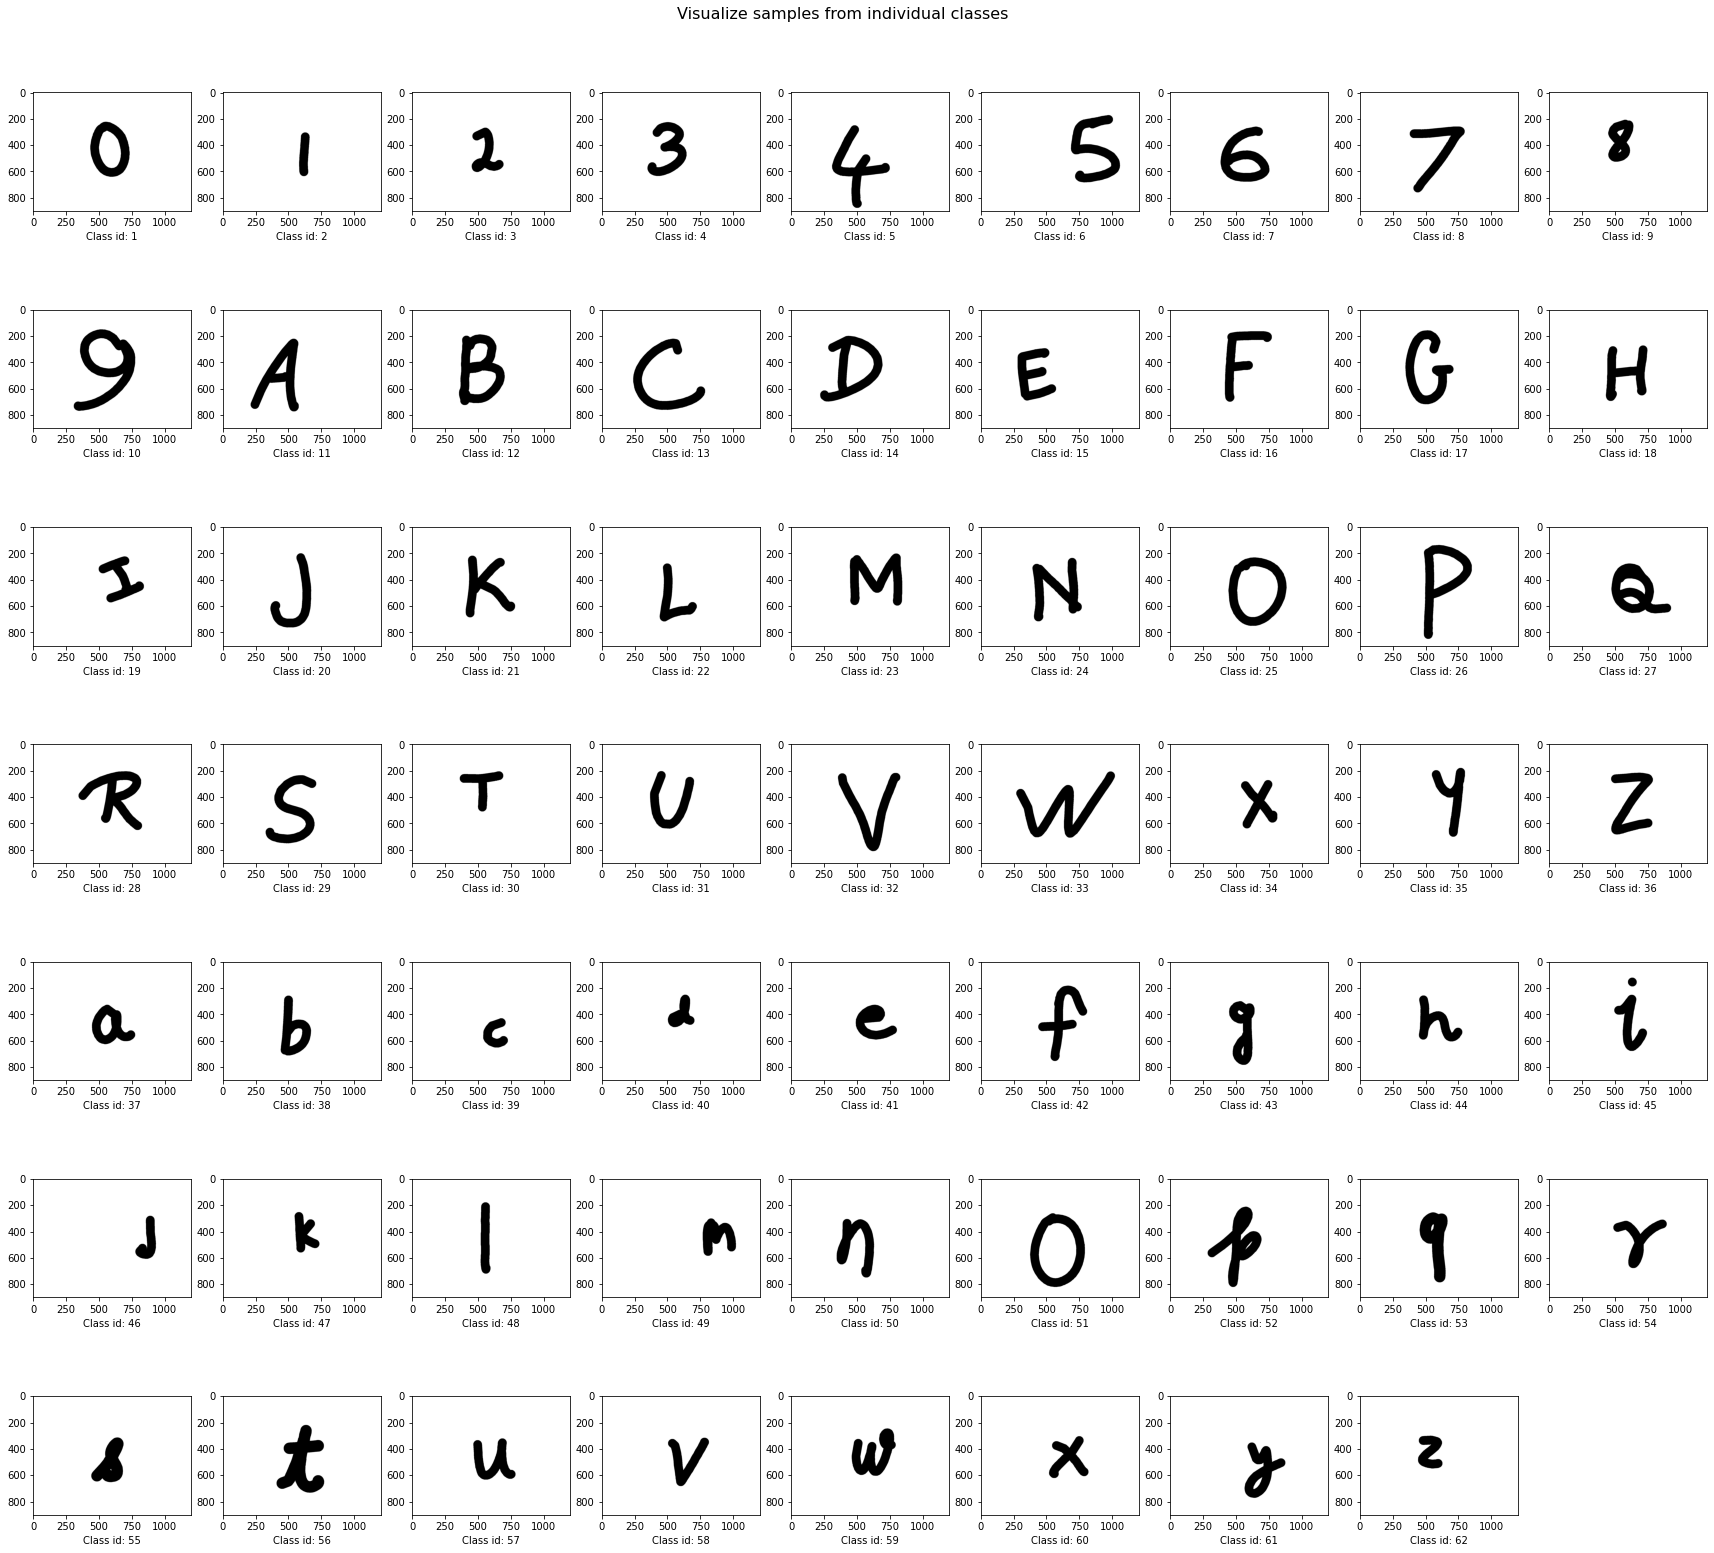

In [11]:
# calling the function to visualize individual random samples
vis_images(img_dir, class_ids)

## Data Loading

**Defining function for creating image array
 and labels list from the folder**

In [12]:
def convert_img_to_array(image_path):
  try:
    img = plt.imread(image_path)
    if img is not None:
      return img_to_array(img)
    else:
      return np.array([])
  
  except Exception as e:
    print(f'Error {e}')
    return None

**Defining function for creating image array and labels list from the folder**

In [13]:
def fetch_img(img_dir):
  samples_list = sorted(os.listdir(img_dir))
  classifiers_path = [os.path.join(img_dir, path) for path in sorted(os.listdir(img_dir))]
  print(f'Classifiers directory names {classifiers_path}')
  # image array list
  image_list = []
  # image labels list
  label_list = []
  # label dataframe
  label_df = pd.DataFrame(columns = sorted(os.listdir(img_dir)))
  # image dataframe
  img_df = pd.DataFrame(columns = ['Image', 'Shape', 'Label'])
  try:
    print('\n[INFO] Acquiring Image Informations ...')
    # total sample count
    sample_count = 0
    for sr, c_path in enumerate(classifiers_path):
      #print(f'[INFO] Processing {samples_list[sr]}')
      path_list = os.listdir(c_path)
      # removing .DS_store files from list if present
      for cs in path_list:
        if cs == '.DS_store':
          path_list.remove(cs)
      
      # categorical count
      count = 0
      for class_sample in path_list:
        class_sample_path = os.path.join(c_path, class_sample)
        if class_sample_path.endswith(".jpg")==True or class_sample_path.endswith(".JPG")==True or class_sample_path.endswith(".png")==True:
          img = convert_img_to_array(class_sample_path)
          #image_list.append(img)
          #label_list.append(class_ids[sr])
          img_df.loc[sample_count, 'Image'], img_df.loc[sample_count, 'Label'] = class_sample, class_ids[sr]
          img_df.loc[sample_count, 'Shape'] = img.shape
          count += 1
          sample_count += 1

      label_df.loc[0, samples_list[sr]] = count
    print('Done!')
    return label_df, img_df
    #image_list, label_list, 

  except Exception as e:
    print(f'Error {e}')
    return None 

In [14]:
# load dataframes for inspection
ldf, img_df = fetch_img(img_dir)

Classifiers directory names ['/content/master_data/train/Sample001', '/content/master_data/train/Sample002', '/content/master_data/train/Sample003', '/content/master_data/train/Sample004', '/content/master_data/train/Sample005', '/content/master_data/train/Sample006', '/content/master_data/train/Sample007', '/content/master_data/train/Sample008', '/content/master_data/train/Sample009', '/content/master_data/train/Sample010', '/content/master_data/train/Sample011', '/content/master_data/train/Sample012', '/content/master_data/train/Sample013', '/content/master_data/train/Sample014', '/content/master_data/train/Sample015', '/content/master_data/train/Sample016', '/content/master_data/train/Sample017', '/content/master_data/train/Sample018', '/content/master_data/train/Sample019', '/content/master_data/train/Sample020', '/content/master_data/train/Sample021', '/content/master_data/train/Sample022', '/content/master_data/train/Sample023', '/content/master_data/train/Sample024', '/content/m

## Target Distribution in the Dataset

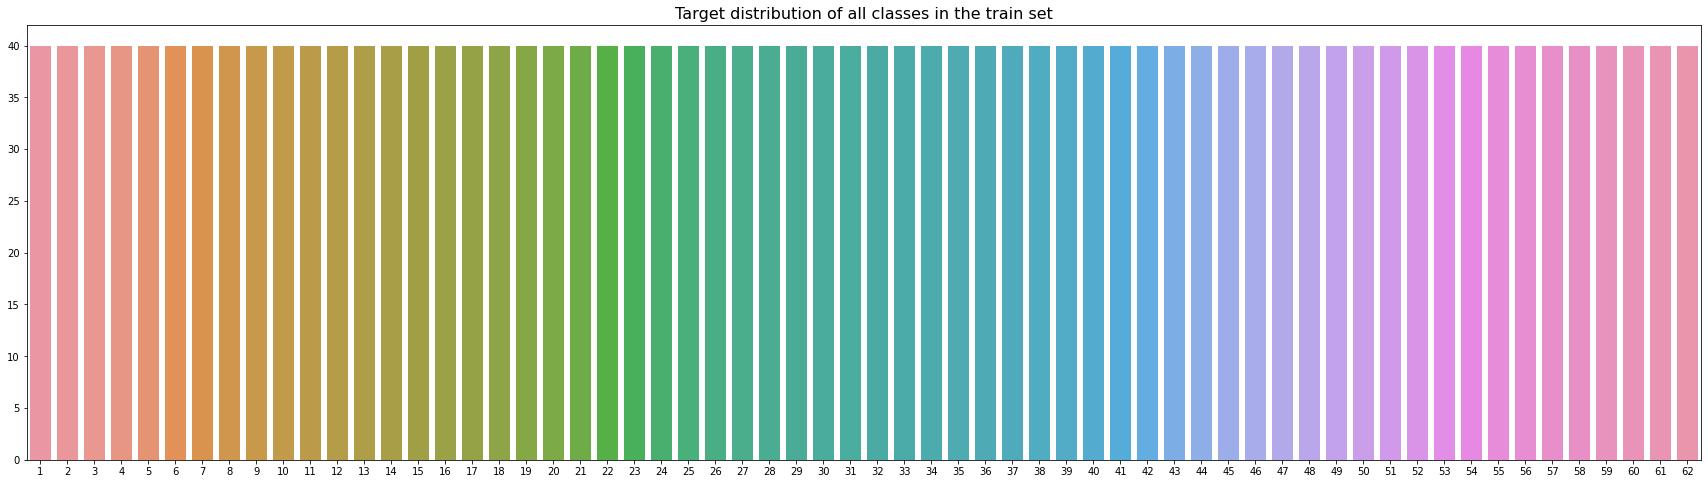

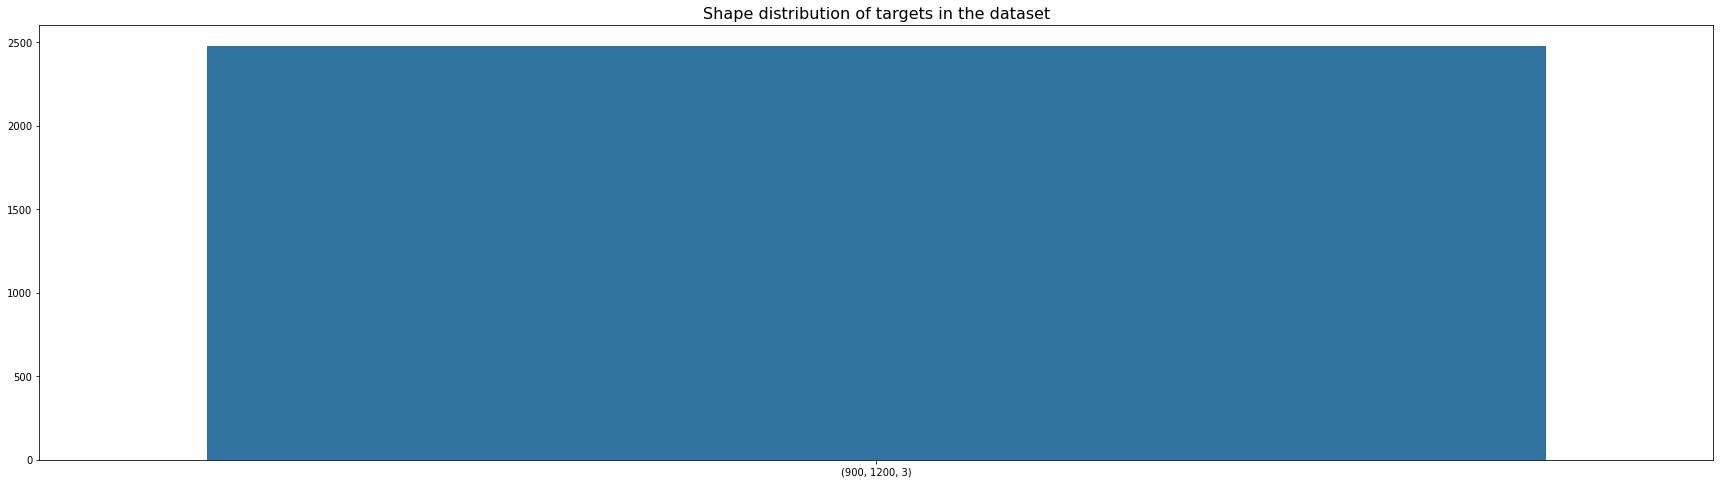

In [15]:
def distribution_vis(counts_series_train, label):
  '''
  Target data distribution in the train data
  '''
  fig = plt.figure(figsize=(30,8))
  sns.barplot(x = counts_series_train.index, y = counts_series_train.values)
  plt.title(label, fontsize = 16)

# returns pandas series with classes as keys and count as values fo train set
target_counts_train = img_df['Label'].value_counts()

# shape analysis for train set
shape_counts_train = img_df['Shape'].value_counts()

# visualize target distribution
distribution_vis(target_counts_train, label = 'Target distribution of all classes in the train set')

# visualize the shape distribution
distribution_vis(shape_counts_train, label = 'Shape distribution of targets in the dataset')

**Conclusion:**

* From the above analysis, the distribution of all the classes in the datasets are equal, i.e 40 samples for each class.
* Also, the shapes of all the samples across the dataset are equal to (900,1200,3)


# Data Pre-processing

Discussion:

Based on the target data to be tested that is the MNIST data, following pre-processing steps are used
1. Rescaing
2. Resizing(Interpolation technique check needed) to target size (28,28)
3. Changing color mode to reduce number of channels.
4. Creating Batches

## Interpolation check

Here we will compare between two of the popular interpolation methods with target size (28,28)

**1. Bilinear spline**, 
**2. Bicubic spline**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 0, 'After Bicubic Interpolation')

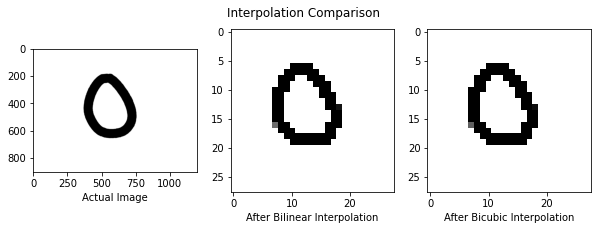

In [16]:
# obtain a random category from the dataset
img_cat = random.choice(os.listdir(img_dir))
# folder path
cat_path = os.path.join(img_dir,img_cat)

# obtain random sample corresponding to the category
img_name = random.choice(os.listdir(cat_path))
# image path
img_path = os.path.join(cat_path, img_name)
# obtain the image
img = plt.imread(img_path)

# bilinear spline interpolation 
img_linear = tf.keras.preprocessing.image.smart_resize(img, size = (28,28),
                                                       interpolation='bilinear')

# bicubic spline interpolation 
img_cubic = tf.keras.preprocessing.image.smart_resize(img, size = (28,28),
                                                       interpolation='bicubic')


fig = plt.figure(figsize = (10,3))
fig.suptitle('Interpolation Comparison')

# before interpolation
fig.add_subplot(131)
plt.imshow(img)
plt.xlabel('Actual Image')

# after bilinear
fig.add_subplot(132)
plt.imshow(img_linear)
plt.xlabel('After Bilinear Interpolation')

# after bicubic
fig.add_subplot(133)
plt.imshow(img_cubic)
plt.xlabel('After Bicubic Interpolation')


**Conclusion:** On going through several samples we can find Bicubic Interpolation is the suitable here.

## Image pre-peocessing using keras ImageDataGenerator

**Steps**

1. Test 1

* Only rescaling is used to normalize the image in 1st pre-processing step. Later based on model performance further techniques can be added.
* For the flow from directory batch size = 32, shuffle = True, class_mode = Sparse, seed = 1 used.

[Reference](https://keras.io/api/preprocessing/image/)

In [17]:
# creating imagedatagenerator object using keras
train_datagen = ImageDataGenerator(rotation_range=None,
                                   width_shift_range = None,
                                   height_shift_range = None,
                                   brightness_range = None,
                                   zoom_range = 0.0,
                                   rescale = 1./255.,
                                   preprocessing_function = None,
                                   dtype = np.float32)

# provide same seed and keyword arguments to the fit and flow methods 
seed = 1

# obtaining images from tarin directory and apply augmentation using train datagen to create batches
train_generator = train_datagen.flow_from_directory(directory=img_dir,
                                                    target_size = (28,28),
                                                    color_mode = "grayscale", # images are converted to grayscale
                                                    classes = None,
                                                    class_mode = "sparse", # sparse categorical helps to reduce space
                                                    batch_size = 32,
                                                    shuffle = True,
                                                    seed = seed
)

Found 2480 images belonging to 62 classes.


## Sample images after preprocessing

Defining the visualization function to visualize individual sample of each class

In [18]:
def img_label_samples(train_generator, class_count = 62):
  '''
  Fetches 1st sample of each class from 0 to 61
  Along with the class label or id
  Takes total class samples to be visualized 
  Batch count as attributes
  '''
  # total batches in the train datagenerator
  batch_count = len(train_generator)
  # image list initialization
  img_list = []
  # labels list
  labels = []

  for cls in range(class_count):
    for batch in range(batch_count):
      # traversing through image label or class id
      # O-> Batch, 1-> Class(for 1, 0 for image), 2-> Index of each image in the batch(0 to 31)
      for i, j in enumerate(train_generator[batch][1][:]):
        if int(j)==cls:
          img_list.append(train_generator[batch][0][i])
          labels.append(int(j))
          break
      if int(j) == cls:
        break
  return img_list, labels 

# obtain image and label list from train_generator
img_list, labels = img_label_samples(train_generator)

Defining function for sample visualization

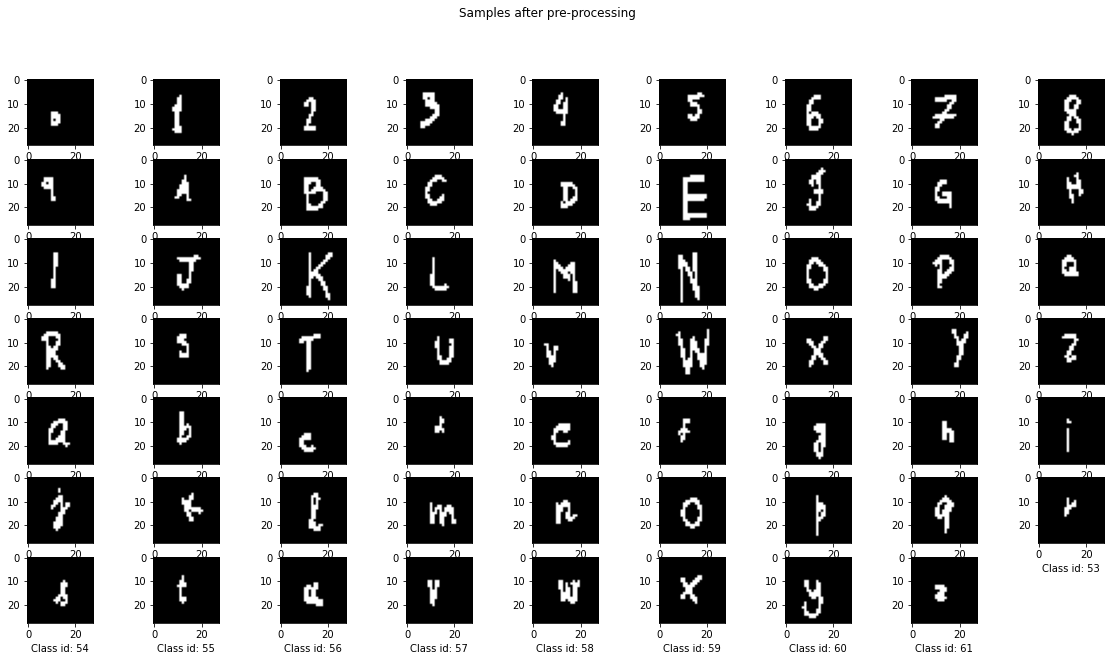

In [19]:
def vis_gen(img_list, labels):
  '''
  62 samples will be visualized
  '''
  cols = 9
  rows = np.ceil(len(img_list)/9)
  fig = plt.figure(figsize=(20,10))
  fig.suptitle('Samples after pre-processing')
  fig.tight_layout()
  for i, c in enumerate(img_list):
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(np.squeeze(c), cmap = 'binary')
    plt.xlabel(f'Class id: {labels[i]}')

  plt.show()

# calling the visualization fn
vis_gen(img_list, labels)


# **Model Building**

Test steps
1. In the 1st test a simple custom model archutecture is used using keras functional API

In [20]:
# input image shape = (28,28,1)
input_shape = train_generator.image_shape
# num_classes = 62
num_classes = train_generator.num_classes
print(f'Model input_shape {input_shape}')
print(f'Number of output class {num_classes}')

Model input_shape (28, 28, 1)
Number of output class 62


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
batch_normalization_3 (Batch (None, 26, 26, 64)        256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 10816)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               5538304   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0     

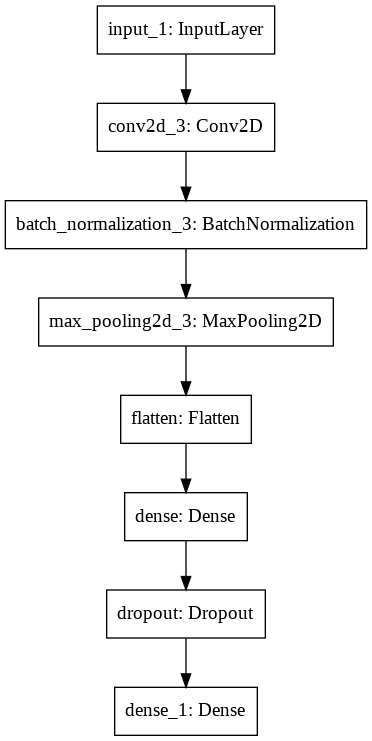

In [21]:
def model(input_shape, num_classes):
  '''
  Defining the model with keras fuctional API
  '''
  inputs = keras.layers.Input(shape = input_shape)

  x = keras.layers.Conv2D(filters = 16, kernel_size= 3, activation = 'relu', strides = 1)(inputs)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.MaxPooling2D(pool_size=2, strides = 2)(x)
  x = keras.layers.Conv2D(filters = 32, kernel_size= 3, activation = 'relu', strides = 1)(inputs)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.MaxPooling2D(pool_size=2, strides = 2)(x)
  x = keras.layers.Conv2D(filters = 32, kernel_size= 3, activation = 'relu', strides = 1)(inputs)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.MaxPooling2D(pool_size=2, strides = 2)(x)
  x = keras.layers.Conv2D(filters = 64, kernel_size= 3, activation = 'relu', strides = 1)(inputs)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.MaxPooling2D(pool_size=2, strides = 2)(x)
  x = keras.layers.Flatten()(x)
  x = keras.layers.Dense(512, activation='relu')(x)
  x = keras.layers.Dropout(rate=0.3)(x)
  output = keras.layers.Dense(num_classes, activation='softmax')(x)
  
  return keras.models.Model(inputs = inputs, outputs = output)

model = model(input_shape, num_classes)
model.summary()
# save the model structure as image
plot_model(model)

# Model Training

#### Defining Hyperparameters and metadata



In [36]:
# initial/ optimal LR
learning_rate = 0.001 # tobe tuned using scheduler
epochs = 10
loss_fn = 'sparse_categorical_crossentropy'

#### Configuring wandb to initialize and log training

Weights and Biases will help to track the training log, checkpoints and create custom project report, here we will use it to record and create training history and reports respectively.

[Reference](https://github.com/wandb/client)

In [23]:
'''
Instruction: Initialize everytime before using wandbcallback and run.join()
'''
# initialize wandb with the project

run = wandb.init(project = 'Master Training',
                 config = {
                     "learning_rate": learning_rate,
                     "epochs": epochs,
                     "batch_size": train_generator.batch_size,
                     "loss_function": loss_fn,
                     "architecture": "CNN",
                     "dataset": 'Trainset'
                 })

# will be used to configure the experiment log for wandb tracking 
config = wandb.config

# defining the optimizer
optimizer = Adam(config.learning_rate)

# model compile
model.compile(optimizer = optimizer, loss = loss_fn, metrics = ['acc'])

wandb: Currently logged in as: sayan0506 (use `wandb login --relogin` to force relogin)


**Storing initial weights of the model for resetting weights**

In [24]:
# use only once after 1st compiling
model.save_weights('model_initial.h5')

#### Defining model callbacks

Callbacks
1. Modelcheckpoint: Model checkpoints will be saved(only weights) after each epoch with the dynamic name of epoch number, validation accuracy
2. Learning rate scheduler is used to make the training curve smooth for better optimality or to choose an optimal learning rate for training
3. Reduce Learnin Rate on Plateu is used to rescue the training curve when it is stuck in a plateu over a sepcified episodes


In [32]:
# model checkpoint
filepath = 'Master_training_epoch_{epoch:02d}.hdf5'
#-acc_{accuracy:0.4d}.hdf5'
# defining model checkpoint object
mc = ModelCheckpoint(filepath = filepath, monitor = 'acc', save_weights_only= True, mode = 'max', verbose = 1)

# reduce Learning rate on Plateu
# if it observes training curve(val_acc) is stuck in plateu, reduces LR by factor 0.2 with patience = 5
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor = 'acc',
                                                 factor = 0.2,
                                                 patience = 5
                                                 )
# schedule Learning rate
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-03/(epoch+1)
)

**Clear the session and reset model weights whenever need to retrain from scratch and restart the session**


In [34]:
# clearing session
keras.backend.clear_session()


Reset weights

In [35]:
# used it when it needed to initialize to train from scratch
model.load_weights('model_initial.h5')
# check initialize
model.evaluate_generator(train_generator)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[4.136873722076416, 0.022983871400356293]

## Model Training

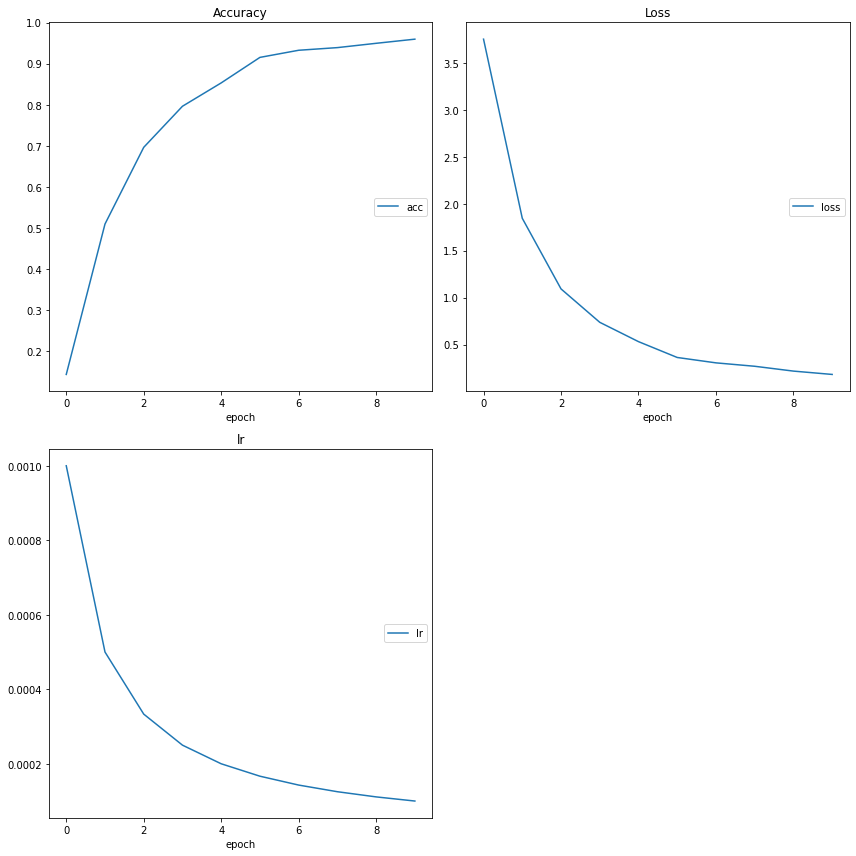

Accuracy
	acc              	 (min:    0.144, max:    0.960, cur:    0.960)
Loss
	loss             	 (min:    0.181, max:    3.753, cur:    0.181)
lr
	lr               	 (min:    0.000, max:    0.001, cur:    0.000)


In [37]:
history = model.fit(train_generator, epochs = epochs, verbose = 1,
                              callbacks = [WandbCallback(), mc, lr_schedule, reduce_lr, PlotLossesKeras()])
                    #, use_multiprocessing = True)